# Stable Diffusion
So far we have been taking advantage of HuggingFaces [StableDiffusionPipeline](https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/text2img) in order to  perform txt2img inference. We have also been using HFs accelerate library and their example [fine tuning scripts](https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/train_text_to_image.py) to fine tune pretrained SD models on our own datasets.

The StableDiffusionPipeline to run txt2img requires 7 different parameters in order to operate:

- vae (AutoencoderKL) — Variational Auto-Encoder (VAE) model to encode and decode images to and from latent representations.
- text_encoder (CLIPTextModel) — Frozen text-encoder (clip-vit-large-patch14).
- tokenizer (CLIPTokenizer) — A CLIPTokenizer to tokenize text.
- unet (UNet2DConditionModel) — A UNet2DConditionModel to denoise the encoded image latents.
- scheduler (SchedulerMixin) — A scheduler to be used in combination with unet to denoise the encoded image latents. Can be one of DDIMScheduler, LMSDiscreteScheduler, or PNDMScheduler.
- safety_checker (StableDiffusionSafetyChecker) — Classification module that estimates whether generated images could be considered offensive or harmful. Please refer to the model card for more details about a model’s potential harms.
- feature_extractor (CLIPImageProcessor) — A CLIPImageProcessor to extract features from generated images; used as inputs to the safety_checker.

In this demo we will explore one of these components in detail - The UNet architecture.

## UNet Architecture

The UNet Diffusion architecture has revolutionized the way in which image generation is orchestrated. The UNet architecture was first introduced in the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf). In this paper Ronneberger, et al. were investigating methods for generating accurate image segmentation in a biomedical context. This model was a great success and since its release in 2015 the UNet has been shown incredible performance in many image related tasks.

In this notebook we are going to take a deep dive into this paper, exploring the details of the architecture. Next, we will implement a basic UNet architecture using PyTorch. For this task we will utilize a predefined dataset from HuggingFace - "segments/sidewalk-semantic" - which will train a model to segment a scene as viewd by a robot moving on a sidewalk. This toy example will serve as a foundation for exploring further the nature of computer vision.

### U-Net: Convolutional Networks for Biomedical Image Segmentation by Olaf Ronneberger, Philipp Fischer, and Thomas Brox
#### Introduction

Motivation: At the time convolution neural networks (CNN) made significant breakthroughs in image classification. In particular thanks to the work of Krizhevsky, et al. who performed supervised training of a large network with millions of parameters trained on ImageNet - a dataset with 1 million training images. These models demonstrated excellent results with respect ot single label classification tasks but fall short when used on other, more compelx visual tasks. In particular solving problems within biomedicla image processing, the desired output should include localization, ie.e a class label is supposed to be assigned to each pixel. An furthermore thousands of training images are usually beyond the reach in these tasks. 

It was demonstrated by [Ciresan et al.](https://arxiv.org/pdf/1202.2745.pdf) that it is possible to train a network with a sliding-window setup to predict the class label of each pixel by providing a local region (patch) around that pixel. This network can localize (classify on a pixel by pixel basis) and due to the use of these patches the dataset becomes much larger. Ronneberger, et al. discuss two specific drawbacks to Ciresan et al.'s work. First the claim it is slow because the entwork must be run separately for each patch, and there is a lot of redundancy due to overlapping patches. Second, there is a trade-off between localization accuracy and the use of co0ntext. Larger patches require more max-pooling layers that reduce the localization accuracy, while small patches allow the network to see only little context.

In this paper they propose a more elegant architecture - the "fully convolutional network". They claim this architecture works with very few training images and yields more precise segmentations. The authors state that one important modification in their architecture is that in the upsampling part they have a larger number of feature channels which allow the network to propogate context information to higher resolution layers. As a consequence, the expansive path ios more or less symetric to the contracting path and yields a u-shaped architecture (Fig. 1) 

<img src="./assets/fig1.png" width="900" />


This sentence leaves me a bit confused - perhaps it will be better understood with implementation context: "To predict the pixels in the border region of the image, the missing context is extrapolated by mirroring the input image."

The team speaks about the challenge of segmentation with respect to touching-objects (like cells). The team proposes the use of a weighted loss, where the separating background labels between touching cells obtain a large weight in the loss function.

#### Network Architecture

Fig. 1 demonstrate the network architecture. It consists of a contracting path and an expansive path. The input image starts as a single channel 572x572 image. This image is considered to have 1 "feature" (the single color channel), in this first block the image each pixel is embedded from this feature space of one to a 64 dimensioned feature space. This transformation into a higher dimension of feature space allows the network to capture hierarchical information from the input image. The contracting path consists of the repeated application of two 3x3 convolutions (unpadded), each followed by a ReLU unit and a 2x2 max pooling operation with stride 2 for downsampling. At each downsampling step the number of feature channels are doubled. This continues until the network passes through a bottleneck, after which the expansion path begins.  Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution ("up-convolution") that halves the feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU. The paper then talks about the cropping that occurs in these expansion stages. They say that it is necessary due to "the loss of border pixels in every convolution." At ther final layer a 1x1 convolution is used to map each 64 component feature vectors to the desired number of classes. In total the network has 23 convolutional layers.

#### Training

The authors begin the training section by addressing several aspects to the run. First they state that they are using input images and their corresponding segmentation maps to train the network using stochastic gradient descent. This process will use unpadded convolutions, so the output images will have a smaller pixel width and height. Additionally, to maximize use of the GPU memory, they favor large input tiles over a large batch size - hence reduce the batch to a single image. A high momentum is used (0.99) 

"The energy function is computed by a pixrel-wise soft-mac over the final feature map combined with the cross entropy loss function." When they speak of the energy function, they also mean the loss function. So each output pixel feature map with be passed through a soft-max function and then the cross entropy loss function. The softmax gives a probability distribution for the value that that pixel might be and cross entropy loss is used to compute the loss between the true probability distribution against the predicted.

#### Softmax Function
For an input vector \( z = [z_1, z_2, ..., z_n] \), the softmax function for each element \( z_i \) is:
$$
\sigma(z)_i = \frac{e^{z_i}}{\sum_{j=1}^{n} e^{z_j}}
$$

#### Cross Entropy Loss
Given a true distribution \( y \) and a predicted distribution \( \hat{y} \), the cross entropy loss is:
$$
L(y, \hat{y}) = -\sum_{i} y_i \log(\hat{y}_i)
$$

#### Weight Map
The authors speak about pre-computing a weight map for each ground truth segmentation "to compoensate the different frequency of pixels from a certian class in the training data set, and to force the network to learn the small seperation borders that we introduce between touching cells"

This seperation border is computed usig a "morphological operation"
$$ w(x) = w_c(x) + w_0 \cdot \exp\left( -\frac{(d_1(x) + d_2(x))^2}{2\sigma^2} \right) $$

I'm not to sure about this section. I think I will have to refer back here when I am building the network for reference.

The authors emphasis that in CNN with many layers and different paths through the network, a good intialization is extremely important. Intial weights are drawn from a Gaussian distribution with a standard deviation of $\sqrt{\frac{2}{N}}$, where $N$ denotes the number of incoming ndoes of one neuron. For a 3x3 convolution and 64 feature channels in the previous layer N = 9*64 = 576

### Data Augmentation

Data augmentation was used in this paper to increase robustness and variance of the dataset. Image shifts, rotations, deformations, and gray value variation was employed to augment the dataset. They also emphasis the use of random elastic deformations of the training samples. This transformation was key to train a segmentation network with very few annotated images. The input images are all 512x512 pixels and gray scale.

###  Conclusion

They researchers found that their technique performed exceptionally well at biomedical segmentation tasks, outperforming all the competing models available at the time.

Now it's time to try and build our own

## Our UNet

For our project we are going to build, train, and evaluate an image segmentation UNet on the "EduardoPacheco/FoodSeg103" dataset. This is a dataset of food and their corresponding 104 segmentation label images.

Let's get to work!

In [15]:
# Let's start out by acquiring our toy dataset
# Since we are using PyTorch to build our model
# Here is some documentation that might be helpful for us: https://huggingface.co/docs/datasets/use_with_pytorch
from datasets import load_dataset

data_checkpoint = "EduardoPacheco/FoodSeg103"

dataset = load_dataset(data_checkpoint)

# Don't forget to download the id2label.json to get the label values. We might need this

dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4983
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 2135
    })
})

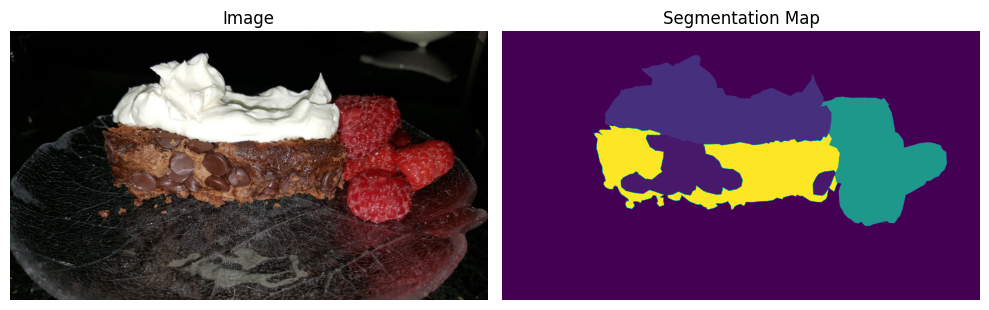

In [25]:
# Let's take a look
import matplotlib.pyplot as plt
import random

ix = random.randint(0, len(dataset["train"]))

fig, ax = plt.subplots(1, 2, figsize=((10,5)))

ax[0].imshow(dataset["train"][ix]["image"], )
ax[0].set_title("Image")
ax[0].axis("off")

ax[1].imshow(dataset["train"][ix]["label"])
ax[1].set_title("Segmentation Map")
ax[1].axis("off")

plt.tight_layout()
plt.show()